In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
eng = create_engine('sqlite:///MTA.db')



# MTA Turnstile Data Analysis

## 1. Load data, create dataframe

In [5]:
df = pd.read_sql('select * from mta', eng)

## 2. Preview data

In [1]:
df.columns

NameError: ignored

In [ ]:
df.info()

In [ ]:
df.describe()

## 3. Data cleaning and preperation

### stripping columns names

In [9]:
#remove white space in last column 
df.rename(columns = {df.columns[-1]:df.columns[-1].strip()},inplace = True)
print(df.columns)

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


In [10]:
df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-08-28 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,00:00:00,REGULAR,7625998,2609113
1,2021-08-28 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,04:00:00,REGULAR,7626014,2609117
2,2021-08-28 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,08:00:00,REGULAR,7626024,2609135
3,2021-08-28 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,12:00:00,REGULAR,7626086,2609191
4,2021-08-28 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,16:00:00,REGULAR,7626206,2609221
...,...,...,...,...,...,...,...,...,...,...,...,...
209255,2021-06-18 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584
209256,2021-06-18 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584
209257,2021-06-18 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584
209258,2021-06-18 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584


### Checking for duplicates
by grouping the rows and counting them we notice 53 duplicates

In [11]:
duplicates =df.groupby(['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION','STATION','DATE_TIME']).ENTRIES.count().reset_index()
duplicates.ENTRIES.value_counts()

1    2513202
2         53
Name: ENTRIES, dtype: int64

Removing the duplicates we found

In [12]:
  df.drop_duplicates(['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION','STATION','DATE_TIME'],inplace = True)

In [13]:
duplicates =df.groupby(['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION','STATION','DATE_TIME']).ENTRIES.count().reset_index()
duplicates.ENTRIES.value_counts()

1    2513255
Name: ENTRIES, dtype: int64

### calculations
by subtracting the entries and exits we get the counts per day

In [56]:
df_stations=df.copy(deep=True)
df_stations['E_DIFF'] = (df
          .groupby(by=['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION','STATION'])
          .ENTRIES.diff()
          .reset_index(drop=True)
          .to_list())
df_stations['EX_DIFF'] = (df
          .groupby(by=['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION','STATION'])
          .EXITS.diff()
          .reset_index(drop=True)
          .to_list())




### checking missing values
after calculating the daily counts we notice missing values in the new columns

In [57]:
df_stations.isna().value_counts()

DATE_TIME  C/A    UNIT   SCP    STATION  LINENAME  DIVISION  DATE   TIME   DESC   ENTRIES  EXITS  E_DIFF  EX_DIFF
False      False  False  False  False    False     False     False  False  False  False    False  False   False      2508226
                                                                                                  True    True          5029
dtype: int64

remove all rows with missing values

In [58]:
df_stations.dropna(subset = ['ENTRIES','E_DIFF','EX_DIFF'],inplace = True)
df_stations.isna().value_counts()

DATE_TIME  C/A    UNIT   SCP    STATION  LINENAME  DIVISION  DATE   TIME   DESC   ENTRIES  EXITS  E_DIFF  EX_DIFF
False      False  False  False  False    False     False     False  False  False  False    False  False   False      2508226
dtype: int64

In [59]:
df_stations.reset_index(inplace=True)
df_stations

,index,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,E_DIFF,EX_DIFF
0,1,2021-08-28 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,04:00:00,REGULAR,7626014,2609117,-6814.0,-2821.0
1,2,2021-08-28 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,08:00:00,REGULAR,7626024,2609135,-7211.0,-2915.0
2,3,2021-08-28 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,12:00:00,REGULAR,7626086,2609191,-7509.0,-2931.0
3,4,2021-08-28 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,16:00:00,REGULAR,7626206,2609221,-7443.0,-3061.0
4,5,2021-08-28 20:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,20:00:00,REGULAR,7626348,2609238,-7384.0,-3161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508221,209255,2021-06-18 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584,0.0,0.0
2508222,209256,2021-06-18 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584,0.0,0.0
2508223,209257,2021-06-18 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584,0.0,0.0
2508224,209258,2021-06-18 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584,0.0,0.0


### validating the counts
whenever the count is less than 1000 we take the original entries otherwise we take the absolte value of the count

In [60]:
df_stations['E_DIFF'] = (np.where(
    ((df_stations.ENTRIES + df_stations.E_DIFF)< -1000),
     df_stations.ENTRIES, abs(df_stations.E_DIFF)))

df_stations['EX_DIFF'] = (np.where(
    ((df_stations.ENTRIES + df_stations.EX_DIFF)< -1000),
     df_stations.ENTRIES, abs(df_stations.EX_DIFF)))



### time frames
we group all the time stampes under common time frames

In [61]:
df_stations['FRAME'] = (np.where((df_stations.DATE_TIME.dt.hour <= 4),4
                          ,np.where((df_stations.DATE_TIME.dt.hour <= 8),8
                                    ,np.where((df_stations.DATE_TIME.dt.hour <= 12),12
                                              ,np.where((df_stations.DATE_TIME.dt.hour <= 16),16
                                                        ,np.where((df_stations.DATE_TIME.dt.hour <= 20),20,0))))))




### Total count per time frame
we calculate the totaly count using the entries and exits count

In [62]:
df_stations['TOTAL'] = abs(df_stations.E_DIFF + df_stations.EX_DIFF)

### Total traffic per station
grouping all rows under their station allows to get the total traffic for the station

In [63]:

df_stations = df_stations.groupby(['STATION']).TOTAL.sum().reset_index()
df_stations.sort_values(by=['TOTAL'],inplace=True,ascending=False)

### finding outliers

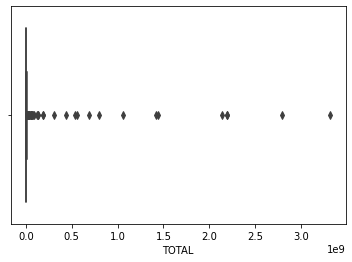

In [ ]:

sns.boxplot(data = df_stations.sort_values(['TOTAL'],ascending = False),x =df_stations.sort_values(['TOTAL'],ascending = False).TOTAL)

taking the subset without the outliers

count    3.790000e+02
mean     5.939993e+07
std      3.213999e+08
min      3.002830e+05
25%      1.068886e+06
50%      1.982014e+06
75%      4.729818e+06
max      3.319777e+09
Name: TOTAL, dtype: float64

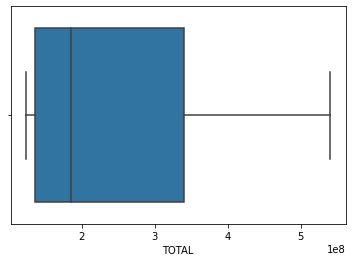

In [166]:
clean = df_stations[np.abs(df_stations.TOTAL-df_stations.TOTAL.std()) <= (0.7*df_stations.TOTAL.std())]


sns.boxplot(data = clean.sort_values(['TOTAL'],ascending = False),x =clean.sort_values(['TOTAL'],ascending = False).TOTAL)
df_stations.TOTAL.describe()

In [167]:
clean

,STATION,TOTAL
264,KINGSTON AV,540501943.0
236,GUN HILL RD,438557875.0
26,170 ST,307609660.0
201,DITMAS AV,185327937.0
340,SMITH-9 ST,185074917.0
61,34 ST-PENN STA,136987099.0
364,W 8 ST-AQUARIUM,135487073.0
78,50 ST,123712116.0


### Traffic per sation

[Text(0, 0, 'ATL AV-BARCLAY'),
 Text(0, 0, 'KINGSTON AV'),
 Text(0, 0, 'GUN HILL RD'),
 Text(0, 0, '170 ST'),
 Text(0, 0, 'DITMAS AV'),
 Text(0, 0, 'SMITH-9 ST'),
 Text(0, 0, '34 ST-PENN STA'),
 Text(0, 0, 'W 8 ST-AQUARIUM'),
 Text(0, 0, '50 ST'),
 Text(0, 0, 'JKSN HT-ROOSVLT')]

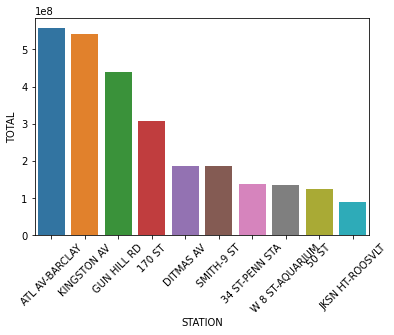

In [159]:
chart = sns.barplot(x=clean.STATION.head(10),y=clean.TOTAL.head(10))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

### annalyize a given station
a function that will get what we need for each station and graph it

In [140]:
def get_station(name):
  
  station = df[df.STATION == name].sort_values("DATE_TIME", ascending=False).reset_index(drop=True).copy(deep = True)


  station['E_DIFF'] = (station
                      .groupby(by=['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION'])
                      .ENTRIES.diff()
                      .reset_index(drop=True)
                      .to_list())
  station['EX_DIFF'] = (station
                      .groupby(by=['C/A',	'UNIT',	'SCP','LINENAME',	'DIVISION'])
                      .EXITS.diff()
                      .reset_index(drop=True)
                      .to_list())
  station.dropna(subset = ['ENTRIES','E_DIFF','EX_DIFF'],inplace = True)

  station['E_DIFF'] = np.where(((station.ENTRIES + station.E_DIFF)< -8000), station.ENTRIES, abs(station.E_DIFF))
  station['EX_DIFF'] = np.where(((station.ENTRIES + station.EX_DIFF)< -8000), station.ENTRIES, abs(station.EX_DIFF))

  station['FRAME'] = (np.where((station.DATE_TIME.dt.hour <= 4),4
                            ,np.where((station.DATE_TIME.dt.hour <= 8),8
                                      ,np.where((station.DATE_TIME.dt.hour <= 12),12
                                                ,np.where((station.DATE_TIME.dt.hour <= 16),16
                                                          ,np.where((station.DATE_TIME.dt.hour <= 20),20,0))))))
  station['TOTAL'] = abs(station.E_DIFF + station.EX_DIFF)
  station=station.groupby(by = ['FRAME'],as_index=False)[['E_DIFF','EX_DIFF','TOTAL']].sum().reset_index(drop=True)


  sns.barplot(x= station.FRAME, y = station.TOTAL)

In [172]:
stations = ['GUN HILL RD','50 ST','DITMAS AV']

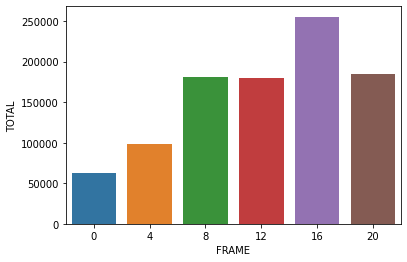

In [173]:
get_station(stations[0])


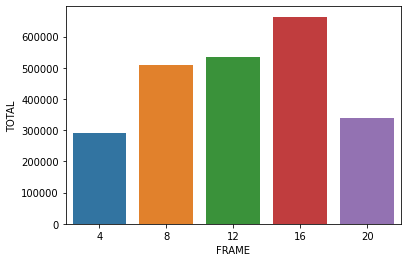

In [174]:
get_station(stations[1])


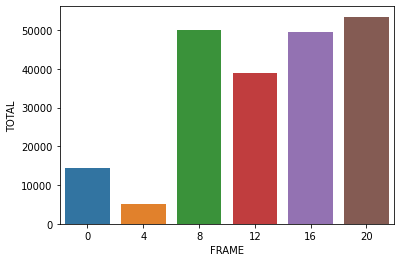

In [175]:
get_station(stations[2])
